# Overview

This analysis is using my personal listneing history from July 5, 2020 to December 28, 2020. Data was retreieved by connecting my spotify account to lastfm to be able to track everything I listen to. I then used pylast, and the spotify API to generate the dataframe being used in this analysis.

# Import Libraries

In [1]:
import pandas as pd
from datetime import datetime
import pytz
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np

# Define Functions

In [2]:
def create_histogram(df, col):
    new_df = df.dropna()
    fig = px.histogram(df, x=col)
    fig.show("png")
    
def create_distplot(df, col):
    new_df = df.dropna()
    hist_data = [new_df[col].tolist()]
    group_labels = ["{0}_label".format(col)]

    fig = ff.create_distplot(hist_data, group_labels)
    fig.show("png")

# Read in the data from csv file

In [3]:
listening_history_df = pd.read_csv("listening_history_2020_12_28.csv")

In [4]:
# Need to format the data to be able to extract the month and year properly 
local_format = "%d %b %Y, %H:%M"
gmt = pytz.timezone("GMT")
eastern = pytz.timezone("US/Eastern")

listening_history_df["playback_date_new"] = [datetime.strptime(val, local_format) for val in listening_history_df["playback_date"]]
listening_history_df["eastern_time"] = [gmt.localize(val).astimezone(eastern) for val in listening_history_df["playback_date_new"]]
listening_history_df["month"] = [val.month for val in listening_history_df["eastern_time"]]
listening_history_df["listening_year"] = [val.year for val in listening_history_df["eastern_time"]]
listening_history_df["year"] = [int(val.split("-")[0]) for val in listening_history_df["release_date"]]

### Top Tracks
As you can see, there is stark contrast in the music that I listen to :) 

In [5]:
listening_history_df["title"].value_counts().reset_index().head(n=10)

,index,title
0,Laugh Now Cry Later (feat. Lil Durk),109
1,Woodlawn,90
2,Build My Life,78
3,Plastic Love,76
4,I Want You Around,76
5,All I Need (with Mahalia & Ty Dolla $ign),68
6,Chicago Freestyle (feat. Giveon),67
7,Where Were You in the Morning?,62
8,Dragonball Durag,61
9,Dynamite,60


### Top Artists
Ah yes, Drake as the top spot once again. It has been Drake for the last 3 years or so, gotta stay loyal to my guy from the 6ix.

In [6]:
listening_history_df["artist"].value_counts().reset_index().head(n=10)

,index,artist
0,Drake,535
1,Kanye West,380
2,Hillsong Worship,352
3,Frank Ocean,343
4,Shawn Mendes,312
5,Housefires,310
6,Elevation Worship,228
7,Aminé,218
8,Jaden,186
9,BTS,179


# Repeated Songs
These are the songs that were most played in a single day. Shawn Mendes took over for a day and also Tori Kelly's cover took me by surprise 

In [7]:
repeat_df = listening_history_df.groupby(['listening_year','month','weekday','title','artist']).size().reset_index()
repeat_df.columns = ['year','month','weekday','title','artist','count']
repeat_df.sort_values('count', ascending=0).head(n=15)

,year,month,weekday,title,artist,count
4799,2020,10,2,Where Were You in the Morning?,Shawn Mendes,16
1724,2020,8,2,Anthem // Great Are You Lord - Live,Phil Wickham,16
1734,2020,8,2,Build My Life,Housefires,14
5686,2020,11,0,Time Flies,Tori Kelly,14
5084,2020,10,4,Cornerstone - Live,Hillsong Worship,12
1745,2020,8,2,Called Me Higher - Live,All Sons & Daughters,12
6573,2020,11,6,Cornerstone - Live,Hillsong Worship,12
4597,2020,10,1,Sunflower,Pauline Zoe Park,12
6335,2020,11,4,Telepathy,BTS,12
6606,2020,11,6,King Of Kings,Hillsong Worship,12


### Exploring genre data
To properly look at the genre data we first need to format them. They show up as a single column that looks something like ['hip hop', 'pop']. I had to parse every unique genre out and then see which ones showed up for every track.

In [8]:
genre_cleanup_df = listening_history_df[["artist","genres"]].drop_duplicates().dropna()
genres = list(set(genre_cleanup_df["genres"]))

In [9]:
cleaned_genres = [
    (((val
             .replace("'","")) # Get rid of '
            .replace("[","")) # Get rid of [
        .replace("]","")) # Get rid of ]
    .split(", ") # Turn the string into a list
    
    for val in genres if val != "[]"
]

# Getting a list of the unique genres
final_genre_list =  list(set(sum(cleaned_genres, [])))

In [10]:
for val in final_genre_list:
    genre_cleanup_df[val] = np.nan
    new_list = []
    for elem in genre_cleanup_df["genres"]:
        if val in elem:
            new_list.append(1)
        else:
            new_list.append(0)
    genre_cleanup_df[val] = new_list

In [11]:
genre_counts = genre_cleanup_df[final_genre_list].sum().reset_index()
genre_counts.columns = ["genre","count"]

Looking at the results for the top 15 genres, it is not too surprising. We can see pop on top as there is overlap with hip hop and rap as well 

In [12]:
hip_hop_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["hip hop"] == 1)])
rap_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["rap"] == 1)])
rb_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["r&b"] == 1)])

print("There are {0} pop songs that overlap with hip hop".format(hip_hop_overlap))
print("There are {0} pop songs that overlap with rap".format(rap_overlap))
print("There are {0} pop songs that overlap with r&b".format(rb_overlap))

There are 124 pop songs that overlap with hip hop
There are 184 pop songs that overlap with rap
There are 161 pop songs that overlap with r&b


In [13]:
genre_counts.sort_values("count",ascending=0).head(n=15)

,genre,count
604,pop,627
115,hip hop,390
438,rap,382
249,r&b,370
238,soul,289
265,alternative r&b,175
424,trap,167
355,rock,166
62,dance pop,148
415,christian,141


In [14]:
unique_genres = len(final_genre_list)
print("There are {0} unqiue genres that you listen to".format(unique_genres))

There are 708 unqiue genres that you listen to


Something interesting is how many regional sub genres there are. Some examples below include the pop and hip hop genres. I had no idea there were this many sub genres and I had no idea I listened to irish hip hop :shrug:

In [15]:
pop_sub_genres = [val for val in final_genre_list if "pop" in val]
print("There are {0} pop sub-genres\n".format(len(pop_sub_genres)))
print(pop_sub_genres)

There are 103 pop sub-genres

['musica popular mineira', 'channel pop', 'classic swedish pop', 'pop rock', 'modern alternative pop', 'puerto rican pop', 'experimental pop', 'social media pop', 'canadian pop', 'dance pop', 'candy pop', 'etherpop', 'pop soul', 'latin pop', 'shiver pop', 'swedish electropop', 'soda pop', 'bedroom pop', 'teen pop', 'bow pop', 'europop', 'la pop', 'indie dream pop', 'australian pop', 'ghanaian pop', 'electropop', 'indie poptimism', 'nz pop', 'indie cafe pop', 'modern power pop', 'classic country pop', 'pop r&b', 'modern indie pop', 'hip pop', 'nederpop', 'vapor pop', 'j-poprock', 'japanese city pop', 'pop rap', 'japanese indie pop', 'modern dream pop', 'new wave pop', 'metropopolis', 'hyperpop', 'uk pop', 'art pop', 'korean city pop', 'j-pop', 'psychedelic pop', 'post-teen pop', 'uk alternative pop', 'k-pop boy group', 'pop dance', 'swedish indie pop', 'viral pop', 'indie electropop', 'k-pop girl group', 'pop edm', 'bubblegum pop', 'alternative pop rock', '

In [16]:
hip_hop_sub_genres = [val for val in final_genre_list if "hip hop" in val]
print("There are {0} hip hop sub-genres\n".format(len(hip_hop_sub_genres)))
print(hip_hop_sub_genres)

There are 57 hip hop sub-genres

['belgian hip hop', 'north carolina hip hop', 'psychedelic hip hop', 'bc underground hip hop', 'bronx hip hop', 'east coast hip hop', 'minnesota hip hop', 'south carolina hip hop', 'nigerian hip hop', 'milwaukee hip hop', 'memphis hip hop', 'hip hop', 'industrial hip hop', 'uk hip hop', 'ghanaian hip hop', 'hawaiian hip hop', 'hardcore hip hop', 'harlem hip hop', 'virginia hip hop', 'detroit hip hop', 'indonesian hip hop', 'kentucky hip hop', 'south african hip hop', 'southern hip hop', 'christian hip hop', 'tennessee hip hop', 'nashville hip hop', 'mississippi hip hop', 'experimental hip hop', 'atl hip hop', 'canadian hip hop', 'alternative hip hop', 'uk alternative hip hop', 'conscious hip hop', 'buffalo hip hop', 'asian american hip hop', 'deep underground hip hop', 'zambian hip hop', 'miami hip hop', 'political hip hop', 'ohio hip hop', 'underground hip hop', 'irish hip hop', 'boston hip hop', 'old school hip hop', 'winnipeg hip hop', 'manchester hi

### Top tracks by month
Yes I had a Shawn Mendes phase.

In [17]:
monthly_count = listening_history_df.groupby(["month","title"]).size().reset_index()
monthly_count.columns = ["month","title","count"]

In [18]:
monthly_count.groupby("month").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True)

,month,title,count
0,7,Chicago Freestyle (feat. Giveon),12
1,8,Anthem // Great Are You Lord - Live,38
2,9,Slide (feat. Frank Ocean & Migos),20
3,10,Where Were You in the Morning?,44
4,11,Time Flies,28
5,12,O Holy Night,19


You can see a dropoff of listening in December as I have been on break and away from my computer 

In [19]:
monthly_count_total = listening_history_df.groupby(["month"]).size().reset_index()
monthly_count_total.columns = ['month','count']
monthly_count_total

,month,count
0,7,2736
1,8,3436
2,9,3738
3,10,3206
4,11,2700
5,12,1545


### Top Tracks by Day of Week
0 = Monday, 6 = Sunday. Jesus on Sundays and Drake during the week.

In [20]:
weekday_count = listening_history_df.groupby(["weekday","title"]).size().reset_index()
weekday_count.columns = ["weekday","title","count"]

In [21]:
weekday_count.groupby("weekday").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True)

,weekday,title,count
0,0,Time Flies,28
1,1,Laugh Now Cry Later (feat. Lil Durk),19
2,2,Build My Life,24
3,3,Saved,16
4,4,Laugh Now Cry Later (feat. Lil Durk),18
5,5,Laugh Now Cry Later (feat. Lil Durk),22
6,6,Cornerstone - Live,17


### Top Tracks by Release Date
Here you can see that I am biased to listen to recent music. I always want to try and find the newest bop to stay relevant you know. Although I am a sucker for my 2000's

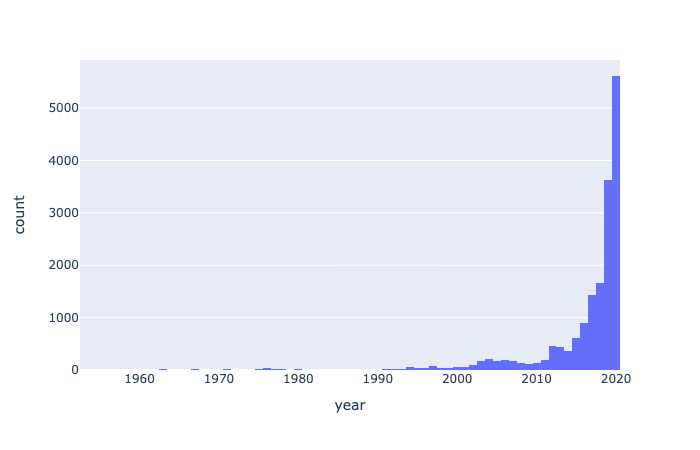

In [22]:
create_histogram(listening_history_df, "year")

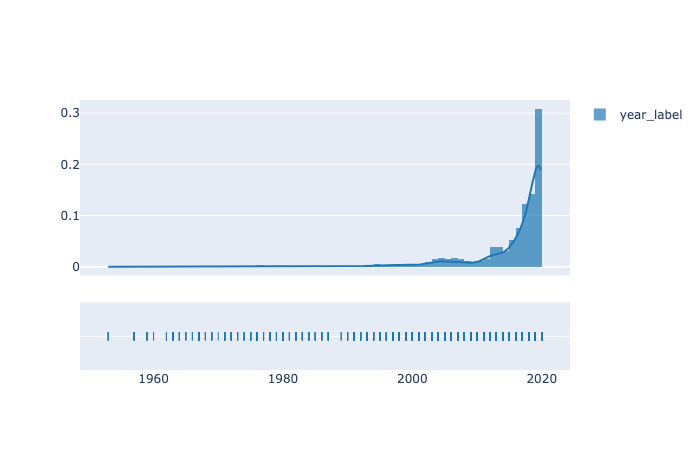

In [23]:
create_distplot(listening_history_df, "year")

In [24]:
yearly_count = listening_history_df.groupby(["year","title"]).size().reset_index()
yearly_count.columns = ["year","title","count"]

In [25]:
yearly_count.groupby("year").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True).sort_values('year',ascending=0).head(n=20)

,year,title,count
61,2020,Laugh Now Cry Later (feat. Lil Durk),109
60,2019,I Want You Around,76
59,2018,Plastic Love,76
58,2017,Slide (feat. Frank Ocean & Migos),53
57,2016,Build My Life,78
56,2015,C U Girl,33
55,2014,Aleluia,39
54,2013,Called Me Higher - Live,35
53,2012,Cornerstone - Live,44
52,2011,Novacane,8


### Distribution of Tracks by popularity
For the most part I am listening to popular music. Somewhat basic I guess

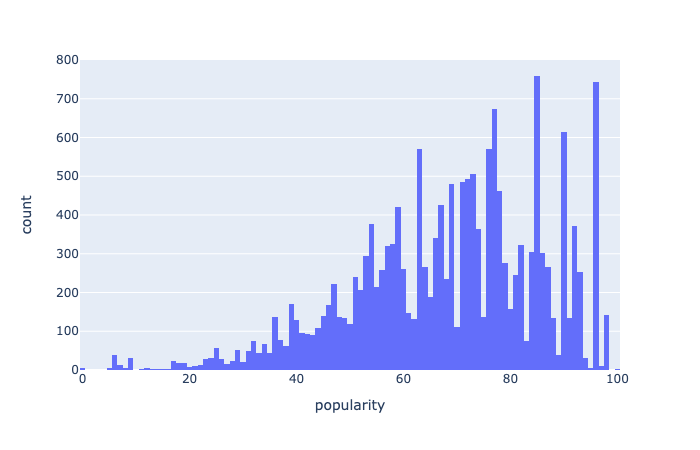

In [26]:
create_histogram(listening_history_df, "popularity")

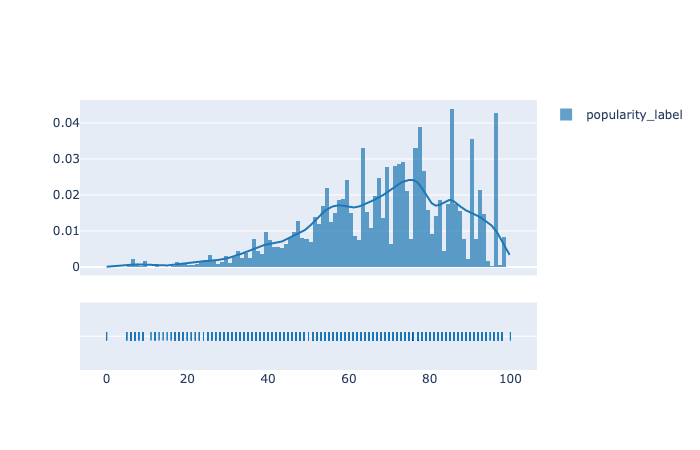

In [27]:
create_distplot(listening_history_df, "popularity")